In [16]:
import datetime as datetime
import pandas as pd
import numpy as np
import numpy_financial as npf
from itertools import accumulate
import absbox as abs
from absbox import API, SPV, Generic, mkDealsBy, setDealsBy,prodDealsBy, viz      #, Portfolio, Risk, Performance, Utils, Data, Analytics, Market, Risk, Utils, Data, Analytics, Market
from absbox.local.analytics import irr, run_yield_table, flow_by_scenario       #npv, 
from absbox.local.util import positionFlow
from dateutil.relativedelta import relativedelta  
from CILibrary.analytics.datetime import Date, dateFromDatetime, dateFromString
from CILibrary.common.DBase import DBase
from CILibrary.analytics.performance.performance import Performance
from CILibrary.analytics.performance.utils import get_index_stats, convert_to_prices
from tabulate import tabulate
from itertools import accumulate
from pyxirr import xirr
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates  
from mpl_toolkits.mplot3d import axes3d
import time
from scipy import optimize
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter  
import seaborn as sns   
import warnings
from lenses import lens

# Suppress FutureWarning messages
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

CI_DB = DBase()
localAPI = API("https://absbox.org/api/dev",check=False)
#localAPI = API("http://localhost:8081",check=False)

Output()

✅Connected, local lib:0.26.1, server:0.26.1

Historical Loan Default Rates

In [17]:
lcd = pd.read_excel('C:\\Users\\yunyizhang\\Python script\\2. Upload data\\LLI Default Rates.xlsx', sheet_name='Default Stats', header=1)
lcd = lcd.iloc[:, :2].set_index('Date').resample('A').mean().reset_index()  
lcd = lcd.rename(columns={'Date': 'Year', 'LTM $ of Defaults / Total Outstanding': 'Loan Default Rates'}).set_index('Year')
lcd = lcd.loc['2008':'2013']
# print(lcd)  

mean = lcd['Loan Default Rates'].mean()  
st_dev = lcd['Loan Default Rates'].std()  
print("Entire History: ", "Mean: ", "{:.2%}".format(mean), "St Dev: ", "{:.2%}".format(st_dev))

threshold = 0.04
print("Annual Default Rate Threshold Above", threshold, "Mean: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] > threshold, 'Loan Default Rates'].mean()), "St Dev: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] > threshold, 'Loan Default Rates'].std()))
print("Annual Default Rate Threshold Below", threshold, ": Mean: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] <= threshold, 'Loan Default Rates'].mean()), "St Dev: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] <= threshold, 'Loan Default Rates'].std()))


Entire History:  Mean:  3.07% St Dev:  3.08%
Annual Default Rate Threshold Above 0.04 Mean:  6.61% St Dev:  2.93%
Annual Default Rate Threshold Below 0.04 : Mean:  1.30% St Dev:  0.61%


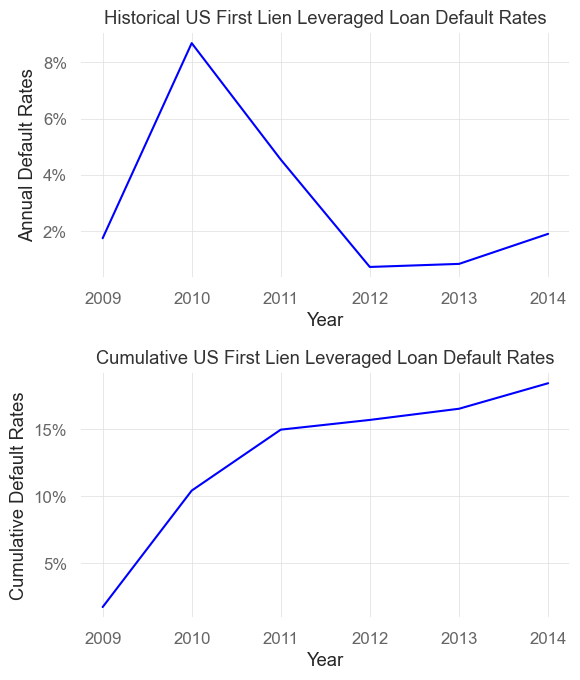

In [18]:
# lcd.loc[lcd.index.year < 2010, 'Loan Default Rates'] *= 2
# lcd.loc[lcd.index.year < 2015, 'Loan Default Rates'] *= 1.5  

fig, axs = plt.subplots(2, 1, figsize=(6, 7))  # 1 row, 2 columns
axs[0].plot(lcd.index, lcd['Loan Default Rates'], color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Annual Default Rates')
axs[0].set_title('Historical US First Lien Leveraged Loan Default Rates')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,0))  
lcd['Cumulative Loan Default Rates'] = lcd['Loan Default Rates'].cumsum()  
axs[1].plot(lcd.index, lcd['Cumulative Loan Default Rates'], color='blue')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Cumulative Default Rates')
axs[1].set_title('Cumulative US First Lien Leveraged Loan Default Rates')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,0))
plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

Monte Carlo Simulation to Create Default Assumptions

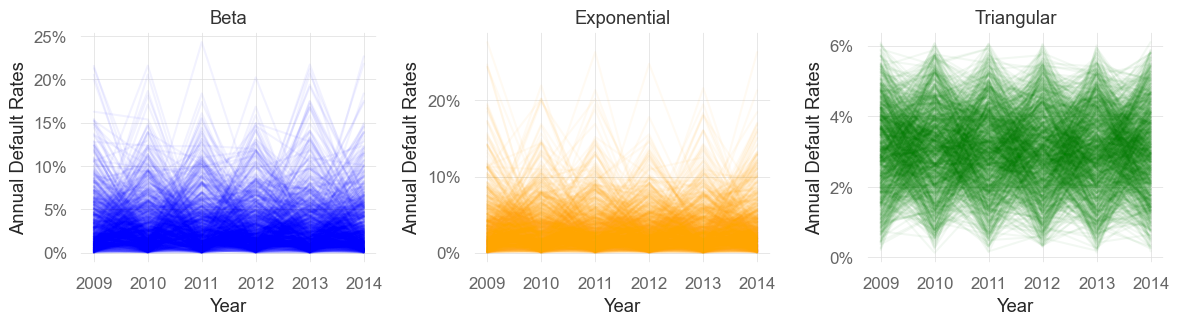

In [19]:
mean = lcd['Loan Default Rates'].mean()  
st_dev = lcd['Loan Default Rates'].std()  
maturity = len(lcd)
np.random.seed(123)  
num_scenarios = 1000
degrees_of_freedom = 10    
default_rates_beta = np.random.beta(mean*(mean*(1-mean)/st_dev**2-1), (1-mean)*(mean*(1-mean)/st_dev**2-1), size=(num_scenarios, maturity))  
default_rates_binomial = np.random.binomial(n=1, p=mean, size=(num_scenarios, maturity))  
default_rates_exponential = np.random.exponential(scale=mean, size=(num_scenarios, maturity))  
default_rates_gamma = np.random.gamma(shape=mean/st_dev**2, scale=st_dev/mean/500, size=(num_scenarios, maturity))  
default_rates_triangular = np.random.triangular(left=mean-st_dev, mode=mean, right=mean+st_dev, size=(num_scenarios, maturity))  
default_rates_lognormal = np.random.lognormal(mean=np.log(mean**2/np.sqrt(st_dev**2+mean**2)), sigma=np.sqrt(np.log(1+st_dev**2/mean**2)), size=(num_scenarios, maturity))  
default_rates_chisquare = np.random.chisquare(df=mean**2/st_dev**2, size=(num_scenarios, maturity)) * st_dev**2/mean  
default_rates_uniform = np.random.uniform(mean, st_dev, size=(num_scenarios, maturity))
default_rates_standardt = np.clip((np.random.standard_t(degrees_of_freedom, size=(num_scenarios, maturity)) * st_dev + mean), 0, 1)

# Plot the default rate scenarios for all distributions  
# distributions = ['Beta', 'Binomial', 'Exponential', 'Gamma', 'Triangular', 'Lognormal', 'ChiSquare', 'Uniform', 'StandardT']  
# colors = ['blue', 'orange', 'green', 'magenta', 'red', 'brown', 'navy', 'gray', 'pink']  
distributions = ['Beta', 'Exponential', 'Triangular']  
colors = ['blue', 'orange', 'green']  

def to_percentage(x, pos):  
    return f"{100 * x:.0f}%"  
def to_percentage_one_decimal(x, pos):  
    return f"{100 * x:.1f}%"  

plt.figure(figsize=(12, 9))  
for i, dist in enumerate(distributions):  
    plt.subplot(3, 3, i+1)  
    for j in range(num_scenarios):  
        plt.plot(lcd.index[:6], eval('default_rates_' + dist.lower())[j][:6], alpha=0.05, color=colors[i])  
        # plt.plot(range(1, 7), eval('default_rates_' + dist.lower())[j][:6], alpha=0.05, color=colors[i])  
    plt.xlabel('Year')  
    plt.ylabel('Annual Default Rates')  
    # plt.title('10,000 Scenarios of Default Rates (' + dist + ' Distribution)')  
    plt.title(dist)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage)) 
plt.tight_layout()  
plt.show()  

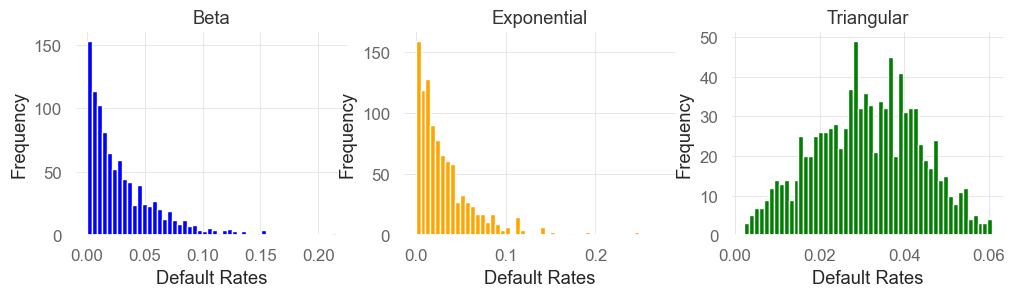

In [20]:
# plot histogram of the default rates for each distribution
plt.figure(figsize=(12, 9))
for i, dist in enumerate(distributions):
    plt.subplot(3, 3, i+1)
    plt.hist(eval('default_rates_' + dist.lower())[:, 0], bins=50, color=colors[i])
    plt.xlabel('Default Rates')
    plt.ylabel('Frequency')
    plt.title(dist)

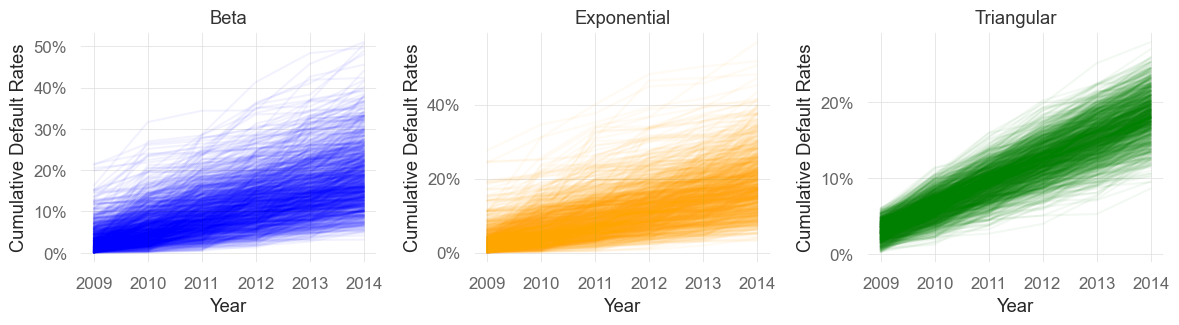

In [21]:
#plot cumulative default curve using all the above distributions 
# cumulative density function (CDF) of the default rates for each distribution
plt.figure(figsize=(12, 9))
for i, dist in enumerate(distributions):
    plt.subplot(3, 3, i+1)
    for j in range(num_scenarios):
        plt.plot(lcd.index[:6], eval('default_rates_' + dist.lower())[j][:6].cumsum(), alpha=0.05, color=colors[i])
    plt.xlabel('Year')
    plt.ylabel('Cumulative Default Rates')
    plt.title(dist)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage)) 
plt.tight_layout()
plt.show()

In [22]:
num_instances = 1_000  # Number of time series to simulate  
num_years = 6  # Number of years to simulate  
scenarios = distributions
all_scenarios_df = pd.DataFrame()  

for scenario in scenarios:  
    all_time_series = pd.DataFrame()  
      
    for n in range(num_instances):  
        if scenario == 'Triangular':  
            default_rates_scenario = default_rates_triangular[np.random.choice(num_scenarios), :]  
        elif scenario == 'Uniform':  
            default_rates_scenario = default_rates_uniform[np.random.choice(num_scenarios), :]  
        elif scenario == 'Lognormal':  
            default_rates_scenario = default_rates_lognormal[np.random.choice(num_scenarios), :]  
        elif scenario == 'Exponential':  
            default_rates_scenario = default_rates_exponential[np.random.choice(num_scenarios), :]  
        # elif scenario == 'Normal':
        #     default_rates_scenario = default_rates_normal[np.random.choice(num_scenarios), :]
        elif scenario == 'StandardT':
            default_rates_scenario = default_rates_standardt[np.random.choice(num_scenarios), :]
        elif scenario == 'Gamma':
            default_rates_scenario = default_rates_gamma[np.random.choice(num_scenarios), :]
        # elif scenario == 'Poisson':
        #     default_rates_scenario = default_rates_poisson[np.random.choice(num_scenarios), :]
        elif scenario == 'Binomial':
            default_rates_scenario = default_rates_binomial[np.random.choice(num_scenarios), :]
        elif scenario == 'ChiSquare':
            default_rates_scenario = default_rates_chisquare[np.random.choice(num_scenarios), :]
        elif scenario == 'Beta':
            default_rates_scenario = default_rates_beta[np.random.choice(num_scenarios), :]
        # elif scenario == 'Geometric':
        #     default_rates_scenario = default_rates_geometric[np.random.choice(num_scenarios), :]
        # elif scenario == 'Weibull':
        #     default_rates_scenario = default_rates_weibull[np.random.choice(num_scenarios), :]
        # elif scenario == 'Gumbel':
        #     default_rates_scenario = default_rates_gumbel[np.random.choice(num_scenarios), :]
        # elif scenario == 'Logistic':
        #     default_rates_scenario = default_rates_logistic[np.random.choice(num_scenarios), :]
        # elif scenario == 'Laplace':
        #     default_rates_scenario = default_rates_laplace[np.random.choice(num_scenarios), :]
        else:
            raise ValueError('Invalid distribution')
          
        default_rates = []  
        for year in range(num_years):  
            if year == 1:  
                default_rate = np.random.choice(default_rates_scenario*2)  
            elif year <= 3:  
                default_rate = np.random.choice(default_rates_scenario*1)  
            elif year <= 5:  
                default_rate = np.random.choice(default_rates_scenario*0.8)  
            else:  
                # default_rate = np.random.choice([0.05, 0.1, 0.15], p=[0.6, 0.3, 0.1])  
                default_rate = np.random.choice(default_rates_scenario*0.5)
            default_rates.append(default_rate)  
          
        lcd = pd.DataFrame({scenario: default_rates}, index=pd.date_range('2023-01-01', periods=num_years, freq='Y'))    
        all_time_series = pd.concat([all_time_series, lcd.T])  
      
    # Adding the median and IQR for each scenario to a summary DataFrame  
    all_time_series_transposed = all_time_series.T  
    median_rates = all_time_series_transposed.median(axis=1)  
    percentile25 = all_time_series_transposed.quantile(0.25, axis=1)  
    percentile75 = all_time_series_transposed.quantile(0.75, axis=1)  
      
    scenario_summary = pd.DataFrame({  
        f'{scenario}_median': median_rates,  
        f'{scenario}_25th': percentile25,  
        f'{scenario}_75th': percentile75  
    })  
      
    if all_scenarios_df.empty:  
        all_scenarios_df = scenario_summary  
    else:  
        all_scenarios_df = all_scenarios_df.join(scenario_summary)  
  
# Now `all_scenarios_df` contains the median and IQR for each year, for all scenarios.  
# You can plot these using a similar approach as before, adjusting for multiple scenarios in the loop.  

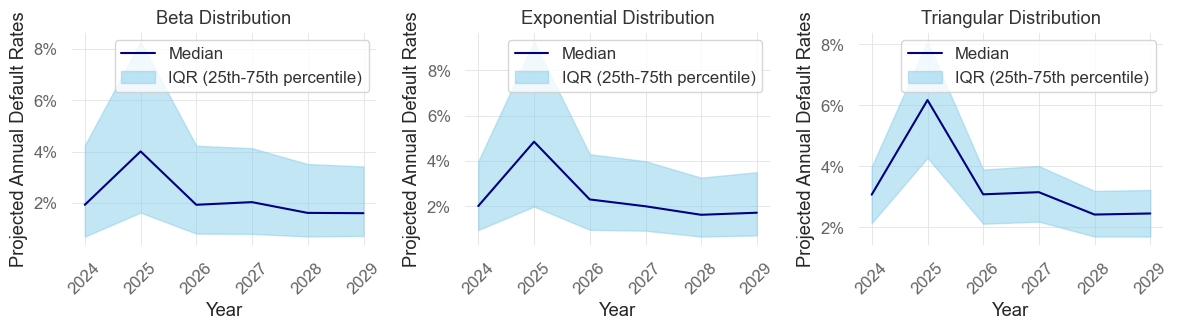

In [23]:
# Set the figure size and create subplots for each scenario  
rows = int(np.ceil(len(distributions) /3))  
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(12, 3.5))  
axes = axes.flatten()  # Flatten to iterate easily  
scenarios = distributions  
  
for i, scenario in enumerate(scenarios):  
    median_label = f'{scenario}_median'  
    p25_label = f'{scenario}_25th'  
    p75_label = f'{scenario}_75th'  
        
    # Plot median  
    axes[i].plot(all_scenarios_df.index, all_scenarios_df[median_label], label='Median', color='navy')  
        
    # Fill between the 25th and 75th percentile (IQR)  
    axes[i].fill_between(all_scenarios_df.index, all_scenarios_df[p25_label], all_scenarios_df[p75_label], color='skyblue', alpha=0.5, label='IQR (25th-75th percentile)')  
        
    # Customize the plot  
    axes[i].set_title(f'{scenario} Distribution')  
    axes[i].set_xlabel('Year')  
    axes[i].set_ylabel('Projected Annual Default Rates')  
        
    # Adjusting X-axis labels  
    axes[i].xaxis.set_major_locator(mdates.YearLocator())  
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
    axes[i].tick_params(axis='x', rotation=45)  
        
    # Format y-axis as percentage  
    axes[i].yaxis.set_major_formatter(FuncFormatter(to_percentage))  
    axes[i].legend()  
  
plt.tight_layout()  
plt.show()  

Create Collateral Pool Cash Flows

In [24]:
all_time_series.columns = [f'Year {i+1}' for i in range(6)]
all_time_series.index = range(1, 1001)
all_time_series

,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6
1,0.007637,0.081345,0.027658,0.014455,0.032538,0.026211
2,0.034090,0.012173,0.006086,0.051386,0.041109,0.041109
3,0.029822,0.059644,0.033100,0.033100,0.023857,0.039629
4,0.021439,0.035206,0.037359,0.046248,0.014082,0.022791
5,0.031979,0.095289,0.038271,0.032161,0.008925,0.038116
...,...,...,...,...,...,...
996,0.025570,0.084418,0.042209,0.025570,0.020456,0.033767
997,0.024693,0.068155,0.021918,0.035738,0.019754,0.033886
998,0.027675,0.077320,0.027675,0.031561,0.010492,0.023230
999,0.009782,0.076341,0.009782,0.009782,0.030536,0.007826


In [34]:
import datetime as datetime
from dateutil.relativedelta import relativedelta  

pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.set_option('display.max_rows', None)

In [26]:
# Pool assumptions 
original_pool_balance = 3_000_000_000
original_pool_term = 3*12
base_rate = 0.04
pool_rate = 0.07 + base_rate
default_rate = 0.01  #[0.03]*36 + [0.01]*36    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 
# defaultFactor = [["2020-10-01",1.05],["2022-10-01",1.15]]
pool_cpr = 12 / original_pool_term   # amortization rate
recovery_rate = 1 - (0.3 * 0.7 + 0.15 * 0.3)   #sensitize this
recovery_lag = 6   #in months

# Deal assumptions
start_date = '2024-01-31' 
original_deal_term = 120      #! change to 120
repay_month = 36               # sensitize this with [24, 30, 36, 42, 48]    
months_to_call = 72
tranche_size_equity = 0.10     #sensitize this, when set to 1, is it just the pool
tranche_size_mezz = 0.10 
tranche_size_senior = 1 - tranche_size_equity - tranche_size_mezz
tranche_rate_equity = 0.10 + base_rate     #this is coupon rate on the tranche  
tranche_rate_mezz = 0.05 + base_rate
tranche_rate_senior = 0.01 + base_rate
issue_price = 1   #can assume back leverage with a value between 0 and 1
reinvestment_rate = 0.00      #replenishment rate for the defaulted positions need to make assumptions too    #risk free rate 

# Remaining calcs
first_pay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+1)  
first_pay_date = first_pay_date.strftime('%Y-%m-%d')
repay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+repay_month)  
repay_date = repay_date.strftime('%Y-%m-%d')  
deal_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_deal_term)
deal_maturity_date = deal_maturity_date.strftime('%Y-%m-%d')  
deal_call_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+months_to_call)
deal_call_date = deal_call_date.strftime('%Y-%m-%d')  
pool_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_pool_term)
pool_maturity_date = pool_maturity_date.strftime('%Y-%m-%d')  


[autoreload of absbox.client failed: Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'RunResp' object layout differs from 'RunResp'
]


In [27]:
import absbox as abs
from absbox import API, SPV, Generic, mkDealsBy, setDealsBy,prodDealsBy, viz      #, Portfolio, Risk, Performance, Utils, Data, Analytics, Market, Risk, Utils, Data, Analytics, Market
from absbox.local.analytics import irr, run_yield_table, flow_by_scenario       #npv, 
from absbox.local.util import positionFlow
import matplotlib.pyplot as plt
from pyxirr import xirr
from lenses import lens
from itertools import accumulate
import pandas as pd
import numpy as np
#import numpy_financial as npf

In [28]:
localAPI = API("https://absbox.org/api/dev",check=False)
#localAPI = API("http://localhost:8081",check=False)

⠸ Connecting engine server -> https://absbox.org/api/dev0m
✅Connected, local lib:0.26.0, server:0.26.2


In [41]:
default_rate = 0.01

perf = ("Pool"            #this is for new assets added into the pool
        ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
        ,None
        ,None
       )

test01 = Generic(
    "TEST01"
    ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
     ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date} #! change deal date
    ,{'assets':[["Mortgage"             #this is snapshot at issuance, confirmed unchanged. this is a fact
        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
          ,"freq":"Monthly","type":"Even","originDate":start_date}
          ,{"currentBalance":original_pool_balance
          ,"currentRate":pool_rate
          ,"remainTerm":original_pool_term
          ,"status":"current"}]]}
    ,(("acc01",{"balance":0}),("acc02",{"balance":0}))  #! change to 0
    ,(("S",{"balance":original_pool_balance * tranche_size_senior
             ,"rate":tranche_rate_senior
             ,"originBalance":original_pool_balance * tranche_size_senior
             ,"originRate":tranche_rate_senior
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_senior}
             ,"bondType":{"Sequential":None}})
      ,("M",{"balance":original_pool_balance * tranche_size_mezz
             ,"rate":tranche_rate_mezz
             ,"originBalance":original_pool_balance * tranche_size_mezz
             ,"originRate":tranche_rate_mezz
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_mezz}
             ,"bondType":{"Sequential":None}
             })
      ,("E",{"balance":original_pool_balance * tranche_size_equity
             ,"rate":tranche_rate_equity
             ,"originBalance":original_pool_balance * tranche_size_equity
             ,"originRate":tranche_rate_equity
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_equity}
             ,"bondType":{"Sequential":None}
             }))
    ,list()
    ,{"revolving":[
          ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
          ,['transfer',"acc02","acc01"]
          # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
          ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
           
         ]
      ,"amortizing":[
          ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
          ,['transfer',"acc02","acc01"]
          # ,['payPrinBySeq',"acc01",["S","M","E"]]
          ,['payPrin',"acc01",["S","M","E"]]
          ,['payIntResidual',"acc01","E"]
       ]
     }
    ,[["CollectedPrincipal","acc01"]
      ,["CollectedRecoveries","acc01"] #! add here
      ,["CollectedPrepayment","acc01"] #! add here
      ,["CollectedInterest","acc02"]]
    ,None
    ,None
    ,None    
    ,{"BeforeDistribution":
       {"dealStatusChange":
        {"condition":[">=",repay_date]
            ,"effects":("newStatus","Amortizing")
            ,"status":False
            ,"curable":False}}
         }
    ,("PreClosing","Revolving")
    )

runDealAssump = [("revolving"     #this is asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance
                    ,["constant"
                      ,["Mortgage"     ##this is what the new assets look like 
                        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
                          ,"freq":"Monthly","type":"Level","originDate":repay_date}
                          ,{"currentBalance":original_pool_balance
                          ,"currentRate":pool_rate
                          ,"remainTerm":original_pool_term
                          ,"status":"current"}]]
                    ,perf)]

r = localAPI.run(test01
                ,runAssump = runDealAssump
                ,poolAssump = ("Pool"
                              ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
                              ,None
                              ,None)
                ,read=True)

⠸0m


In [42]:
def srt(firstLossBal, poolPerformance, issuePrice, feeRate, reinvestRate=reinvestment_rate):
    
    poolDates = poolPerformance['pool']['flow'].index.to_list()
    beginDate = poolDates[0]
    lastDate = poolDates[-1]
    start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
    start['CumLossDerived'] = start['Loss'].cumsum()
    
    #start.loc[:,'FeeBase'] = (start[''] - start['CumLoss']).clip(lower=0).to_list()#Balance
    start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLossDerived']).clip(lower=0).to_list()#tranche balance
    start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * feeRate / 12
    
    start.loc[:,'feePayment'] = start['Balance'] * feeRate / 12
    start.loc[:,'reimburseLoss'] = start['Loss']
    start.loc[:,'netGuarantor'] = start['feePayment'] - start['reimburseLoss']

    start.loc[:,'cashAccountChange'] = 0
    start.loc[beginDate, 'cashAccountChange'] = issuePrice
    start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLossDerived']

    start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
    start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12

    start.loc[:,'netCashflow'] = 0 
    start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
    # start.loc[:,'netCashflow'] += start['feePayment'].fillna(0)
    start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
    start.loc[:,'netCashflow'] += start['cashAccountInt']
    start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']    

    return start

projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
projectCf

/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_90314/675211161.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start['CumLossDerived'] = start['Loss'].cumsum()
/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_90314/675211161.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLossDerived']).clip(lower=0).to_list()#tranche balance
/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_90314/675211161.py:11: Sett

,Balance,Loss,CumLoss,CumLossDerived,protectedTrancheBalance,interestStream,feePayment,reimburseLoss,netGuarantor,cashAccountChange,cashAccountBal,cashAccountInt,netCashflow
Date,,,,,,,,,,,,,
2024-01-31,"3,000,000,000.000",0.000,0.000,0.000,"300,000,000.000","3,500,000.000","35,000,000.000",0.000,"35,000,000.000","300,000,000.000","300,000,000.000",0.000,"-296,500,000.000"
2024-02-29,"2,914,338,580.130",0.000,0.000,0.000,"300,000,000.000","3,500,000.000","34,000,616.768",0.000,"34,000,616.768",0.000,"300,000,000.000",0.000,"3,500,000.000"
2024-03-31,"2,919,090,758.560",0.000,0.000,0.000,"300,000,000.000","3,500,000.000","34,056,058.850",0.000,"34,056,058.850",0.000,"300,000,000.000",0.000,"3,500,000.000"
2024-04-30,"2,922,633,663.040",0.000,0.000,0.000,"300,000,000.000","3,500,000.000","34,097,392.735",0.000,"34,097,392.735",0.000,"300,000,000.000",0.000,"3,500,000.000"
2024-05-31,"2,926,765,060.470",0.000,0.000,0.000,"300,000,000.000","3,500,000.000","34,145,592.372",0.000,"34,145,592.372",0.000,"300,000,000.000",0.000,"3,500,000.000"
2024-06-30,"2,930,380,231.290",0.000,0.000,0.000,"300,000,000.000","3,500,000.000","34,187,769.365",0.000,"34,187,769.365",0.000,"300,000,000.000",0.000,"3,500,000.000"
2024-07-31,"2,934,480,983.360",0.000,0.000,0.000,"300,000,000.000","3,500,000.000","34,235,611.473",0.000,"34,235,611.473",0.000,"300,000,000.000",0.000,"3,500,000.000"
2024-08-31,"2,937,684,407.430","610,623.840","610,623.840","610,623.840","299,389,376.160","3,492,876.055","34,272,984.753","610,623.840","33,662,360.913",0.000,"300,000,000.000",0.000,"3,492,876.055"
2024-09-30,"2,943,356,463.440","653,564.550","1,244,704.120","1,264,188.390","298,735,811.610","3,485,251.135","34,339,158.740","653,564.550","33,685,594.190",0.000,"300,000,000.000",0.000,"3,485,251.135"


In [40]:
# default rate = 0.005
xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())

0.1405601164069976

In [45]:
# default rate = 0.01
xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())

0.12951544427508208